In [1]:
import os
imdb_dir = '/home/jack/文档/deeplearn/第六章/预训练词嵌入/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
print(labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

Using TensorFlow backend.


In [4]:
#在 100 个单词后截断评论
maxlen = 100
#在 200 个样本上训练
training_samples = 200
#在 10 000 个样本上验证
validation_samples = 10000
#只考虑数据集中前 10 000 个最常见的单词
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [5]:
#将数据划分为训练集和验证集,但首先要打乱数据,因为一开始数据中的样本是排好序的(所有负面评论都在前面,然后是所有正面评论)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [6]:
x_train = data[:training_samples]
y_train= labels[:training_samples]
x_val =data[training_samples: training_samples + validation_samples]
y_val =labels[training_samples: training_samples + validation_samples]

In [7]:
#解析 GloVe 词嵌入文件。我们对解压后的文件(一个 .txt 文件)进行解析,构建一个将单词(字符串)映射为其向量表示(数值向量)的索引。
glove_dir = '/home/jack/文档/deeplearn/第六章/预训练词嵌入/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
#准备 GloVe 词嵌入矩阵
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
#嵌入索引( embeddings_index )中找不到的词,其嵌入向量全为 0
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [9]:
#定义模型
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [10]:
#将预训练的词嵌入加载到 Embedding 层中
model.layers[0].set_weights([embedding_matrix])
#需要冻结 Embedding 层(即将其 trainable 属性设为 False )
model.layers[0].trainable = False

In [11]:
#训练模型
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2606 - acc: 0.4550 - val_loss: 0.7003 - val_acc: 0.5095
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5377 - acc: 0.7900 - val_loss: 0.8218 - val_acc: 0.4986
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5362 - acc: 0.7250 - val_loss: 0.6980 - val_acc: 0.5330
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3831 - acc: 0.8700 - val_loss: 1.0032 - val_acc: 0.5052
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.3465 - acc: 0.8650 - val_loss: 0.7197 - val_acc: 0.5293
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2187 - acc: 0.9750 - val_loss: 1.1752 - val_acc: 0.4987
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2388 - acc: 0.9400 - val_loss: 0.6984 - val_acc: 0.5585
Epoch 8/10
200/200 [========

In [12]:
# #在不使用预训练词嵌入的情况下,训练相同的模型
# from keras.models import Sequential
# from keras.layers import Embedding, Flatten, Dense
# model = Sequential()
# model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()
# model.compile(optimizer='rmsprop',
# loss='binary_crossentropy',
# metrics=['acc'])
# history = model.fit(x_train, y_train,
# epochs=10,
# batch_size=32,
# validation_data=(x_val, y_val))

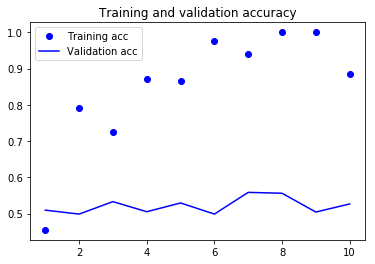

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

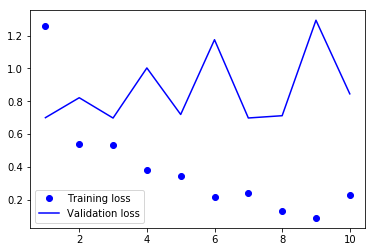

In [14]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
# plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
#最后,我们在测试数据上评估模型
#对测试集数据进行分词
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [16]:
#在测试集上评估模型
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 65us/step


[0.85147016353607174, 0.52927999999999997]